# Voice Conversion Evaluation

In this notebook we evaluate the performance or our voice conversion model(s) by doing the following steps:
- loading data
- creating or loading a voice conversion test dataset
- loading our model
- loading metrics and metric models
- evaluating model performance for individual source-target-pairs
- generating some insights into the results

Parts of this notebook use Code from [Soft-VC](https://github.com/bshall/acoustic-model) as a basis.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Copy and unzip dataset from mounted Google Drive

Copying and unzipping the zip files usually takes around 1-2 minutes per cell for mel data and units.

In [ ]:
drive_vctk_path = '/content/drive/MyDrive/VC/VCTK/'
drive_vctk_wav_text_path = drive_vctk_path + 'VCTK-Corpus-mic1.zip'
drive_vctk_units_path = drive_vctk_path + 'VCTK-Corpus-mic1-units.zip'
drive_vctk_spk_emb_path = drive_vctk_path + 'VCTK-Corpus-mic1-spk_emb.zip'
drive_vctk_spk_emb_win_path = drive_vctk_path + 'VCTK-Corpus-mic1-spk_emb_win.zip'
drive_vctk_spk_emb_agg_path = drive_vctk_path + 'VCTK-Corpus-mic1-spk_emb_agg.zip'
drive_vctk_splits_path = drive_vctk_path + 'splits_ext.json'
drive_vctk_spkinfo_path = drive_vctk_path + 'speaker-info.txt'

In [ ]:
!mkdir /content/vctk

copy audio and texts from google drive

In [ ]:
!cp $drive_vctk_wav_text_path /content/vctk/VCTK-Corpus-mic1.zip

In [ ]:
!unzip -q /content/vctk/VCTK-Corpus-mic1.zip -d /content/vctk

copy units from google drive

In [ ]:
!cp $drive_vctk_units_path /content/vctk/VCTK-Corpus-mic1-units.zip

In [ ]:
!unzip -q /content/vctk/VCTK-Corpus-mic1-units.zip

In [ ]:
!mv /content/content/vctk/units /content/vctk/units

copy spk_emb from google drive

In [ ]:
!cp $drive_vctk_spk_emb_path /content/vctk/VCTK-Corpus-mic1-spk_emb.zip

In [ ]:
!unzip -q /content/vctk/VCTK-Corpus-mic1-spk_emb.zip -d /content/vctk

In [ ]:
!mv /content/vctk/content/vctk/spk_emb /content/vctk/spk_emb

copy spk_emb_win from google drive

In [ ]:
!cp $drive_vctk_spk_emb_win_path /content/vctk/VCTK-Corpus-mic1-spk_emb_win.zip

In [ ]:
!unzip -q /content/vctk/VCTK-Corpus-mic1-spk_emb_win.zip -d /content/vctk

In [ ]:
!mv /content/vctk/content/vctk/spk_emb_win /content/vctk/spk_emb_win

copy spk_emb_agg from google drive

In [ ]:
!cp $drive_vctk_spk_emb_agg_path /content/vctk/VCTK-Corpus-mic1-spk_emb_agg.zip

In [ ]:
!unzip -q /content/vctk/VCTK-Corpus-mic1-spk_emb_agg.zip -d /content/vctk

In [ ]:
!mv /content/vctk/content/vctk/spk_emb_agg /content/vctk/spk_emb_agg

copy dataset split into from google drive

In [ ]:
!cp $drive_vctk_splits_path /content/vctk/splits_ext.json

copy dataset speaker metadata from goole drive

In [ ]:
!cp $drive_vctk_spkinfo_path /content/vctk/speaker-info.txt

copy vc test pairs

In [ ]:
!mkdir /content/vctk/eval-pairs

In [ ]:
!cp /content/drive/MyDrive/VC/VCTK/eval-pairs/* /content/vctk/eval-pairs/

some path definitions

In [ ]:
splits_ext_path = '/content/vctk/splits_ext.json'
speaker_info_path = '/content/vctk/speaker-info.txt'
vctk_path = '/content/vctk'
model_path = '/content/drive/MyDrive/VC'

## Dataset

In [ ]:
from pathlib import Path
import numpy as np

import torch
import torchaudio
from torch.utils.data import Dataset
from torchaudio.functional import resample


class VCTKDataset(Dataset):
    def __init__(self, root: Path, pairs = [], spk_emb_type = 'single'):
        if spk_emb_type == 'single':
            spk_emb_dirname = 'spk_emb'
        elif spk_emb_type == 'win':
            spk_emb_dirname = 'spk_emb_win'
        elif spk_emb_type == 'agg':
            spk_emb_dirname = 'spk_emb_agg'
        else:
            raise ValueError()

        self.spk_emb_type = spk_emb_type
        self.units_dir = root / "units"
        self.spk_emb_dir = root / spk_emb_dirname
        self.wav_dir = root / "wav48_silence_trimmed"
        self.txt_dir = root / "txt"

        self.metadata = [(Path(f"{pair[0][:4]}/{pair[0]}_mic1"),
                          Path(f"{pair[1][:4]}/{pair[1]}_mic1")) for pair in pairs]

    def __len__(self):
        return len(self.metadata)

    def __getitem__(self, index):
        src_path, tgt_path = self.metadata[index]
        units_path = self.units_dir / src_path
        wav_path = self.wav_dir / src_path
        txt_path = self.txt_dir / src_path
        if self.spk_emb_type in ['single', 'win']:
            spk_emb_path = self.spk_emb_dir / tgt_path
        else:  # self.spk_emb_type == 'agg'
            spk_emb_path = self.spk_emb_dir / Path(str(tgt_path)[:4])

        units = np.load(units_path.with_suffix(".npy"))
        spk_emb = np.load(spk_emb_path.with_suffix(".npy"))

        units = torch.from_numpy(units)
        spk_emb = torch.from_numpy(spk_emb)

        wav, sr = torchaudio.load(wav_path.with_suffix(".flac"))
        wav = resample(wav, sr, 16000)
        wav = wav.squeeze()

        with open(Path(str(txt_path)[:-5]).with_suffix(".txt")) as f:
          txt = f.read()
        return f'{str(src_path)[5:-5]}-{str(tgt_path)[5:-5]}', units, spk_emb, wav, txt

    def id_to_index(self, id):
        src_id, tgt_id = id.split('-')
        src_spk = src_id[:4]
        tgt_spk = tgt_id[:4]
        i = 0
        while not (str(self.metadata[i][0]) == f'{src_spk}/{src_id}_mic1' and str(self.metadata[i][1]) == f'{tgt_spk}/{tgt_id}_mic1'):
          i += 1
        return i

    def get_tgt_audio(self, index):
        _, tgt_path = self.metadata[index]
        wav_path = self.wav_dir / tgt_path
        wav, sr = torchaudio.load(wav_path.with_suffix(".flac"))
        wav = resample(wav, sr, 16000)
        wav = wav.squeeze()
        return wav

In [ ]:
import json

with open(splits_ext_path) as f:
    splits = json.load(f)

We generate some metadata for each utterance of the test split of our dataset, namely:
- speaker gender
- audio length in seconds
- whether the speaker was seen in training
- whether the utterance was seen in training

In [ ]:
# train speaker and utts
train_spks = set([spkutt[:4] for spkutt in splits['train']])
train_utts = set([spkutt[5:] for spkutt in splits['train']])
# Metadata
ids = splits['test']
Metadata = {id: {} for id in ids}
with open(speaker_info_path) as f:
    spkinfo = f.readlines()[1:-1]
    #print(len(spkinfo))
G = {line[:4]: line[10] for line in spkinfo}
#print(len(G))
for id, data in Metadata.items():
    spk = id[:4]
    data['gender'] = G[spk]
    # length
    audiopath = f'{vctk_path}/wav48_silence_trimmed/{spk}/{id}_mic1.flac'
    info = torchaudio.info(audiopath)
    data['length'] = info.num_frames / info.sample_rate
    # seen
    data['spk_seen'] = True if spk in train_spks else False
    data['utt_seen'] = True if id[5:] in train_utts else False

### Generation of test source-target-pairs

We have two options to obtain test pairs of a source audio and an audio of a target speaker.
1. Quick on-the-fly pair generation
2. Loading our pre-generated pairs. These were once generated in the on-the-fly section and then stored away.

#### 1. On-the-fly src-tgt pair generation

Here are a few examples of generation of pairs. Central is the `ids` variable from above, which holds the utterance ids. We noticed that for speaker p315 some texts were not present in the dataset, so we left them out.

In [ ]:
import random
from tqdm import tqdm

In [ ]:
# random pairs
N = 100
pairs = []
for _ in tqdm(range(N)):
    id1 = random.choice(ids)
    id2 = random.choice(ids)
    while id1[:4] == id2[:4] or id1[:4] == 'p315':
        id1 = random.choice(ids)
    pairs.append((id1, id2))

100%|██████████| 100/100 [00:00<00:00, 184771.10it/s]


The following 3 cells create pairs from the 3 disjunct parts of the test dataset.

In [ ]:
# alternative pair generation
# many to many pairs
m2m_ids = [id for id in ids if id[:4] in train_spks]
N = 1000
pairs = []
for _ in range(N):
    id1 = random.choice(ids)
    id2 = random.choice(ids)
    while id1[:4] == id2[:4] or id1[:4] == 'p315':
        id1 = random.choice(ids)
    pairs.append((id1, id2))

In [ ]:
# any to any seen utts
a2a_su_ids = [id for id in ids if id[:4] not in train_spks and id[5:] in train_utts]
N = 1000
pairs = []
for _ in range(N):
    id1 = random.choice(ids)
    id2 = random.choice(ids)
    while id1[:4] == id2[:4] or id1[:4] == 'p315':
        id1 = random.choice(ids)
    pairs.append((id1, id2))

In [ ]:
# any 2 any unseen utts
a2a_uu_ids = [id for id in ids if id[:4] not in train_spks and id[5:] not in train_utts]
N = 1000
pairs = []
for _ in range(N):
    id1 = random.choice(ids)
    id2 = random.choice(ids)
    while id1[:4] == id2[:4] or id1[:4] == 'p315':
        id1 = random.choice(ids)
    pairs.append((id1, id2))

In [ ]:
print('m2m_ids', len(m2m_ids))
print('a2a_su_ids', len(a2a_su_ids))
print('a2a_uu_ids', len(a2a_uu_ids))
assert len(m2m_ids) + len(a2a_su_ids) + len(a2a_uu_ids) == len(ids)

Optionally we can store away the pairs like this:

In [ ]:
pair_filename = 'm2m_pairs.json'
#pair_filename = 'a2a_pairs_seen_utts.json'
#pair_filename = 'a2a_pairs_unseen_utts.json'
with open('/content/'+pair_filename, 'w') as f:
  json.dump(pairs, f)

#### 2. Loading already generated test pairs

In [ ]:
with open('/content/vctk/eval-pairs/m2m_pairs.json') as f:
  m2m_pairs = json.load(f)
with open('/content/vctk/eval-pairs/a2a_pairs_seen_utts.json') as f:
  a2a_pairs_seen_utts = json.load(f)
with open('/content/vctk/eval-pairs/a2a_pairs_unseen_utts.json') as f:
  a2a_pairs_unseen_utts = json.load(f)

Run any of the following 3 cells to select a list of test pairs.

In [ ]:
pairs = m2m_pairs

In [ ]:
pairs = a2a_pairs_seen_utts

In [ ]:
pairs = a2a_pairs_unseen_utts

Decide how many pairs to take.

In [ ]:
pairs = pairs[:500]

Create the test dataset.

In [ ]:
# spk_emb_type can be any of 'single', 'win', 'agg'
dataset = VCTKDataset(Path(vctk_path), pairs, spk_emb_type = 'single')

## Model

Our model code lives in the file `model_new.py`.

In [ ]:
import sys
sys.path.append(model_path)
from model import VCModel

### Create model instance

In [ ]:
ckpts_base_path = '/content/drive/MyDrive/VC/ckpts/'
ckpts_AEBase = ckpts_base_path + 'AutoencoderBase_ckpts/ckpts/'
ckpts_AEBaseD = ckpts_base_path + 'AutoencoderBase_Dropout_ckpts/ckpts/'
ckpts_AEBaseDD = ckpts_base_path + 'AutoencoderBase_Dropout_DimIncrease/'
ckpts_AEBaseDDP = ckpts_base_path + 'AutoencoderBase_Dropout_DimIncrease_Postnet_ckpts/ckpts/'
ckpts_AEBaseP = ckpts_base_path + 'AutoencoderBase_PostNet_ckpts/'
ckpts_AEBase_SEW = ckpts_base_path + 'AutoencoderBase_spk_emb_win_ckpts/ckpts/'
ckpts_AEBase_SEA = ckpts_base_path + 'AutoencoderBase_spk_emb_agg_ckpts/ckpts/'

In [ ]:
MORE_DROPOUT = False
DIMINCREASE = False
POSTNET = False

USE_CUSTOM_LSTM = False

CKPT_PATH = ckpts_AEBase  # choose any of the paths from above

In [ ]:
ckpt_name = 'model-best.pt'

model = VCModel(
    more_dropout=MORE_DROPOUT,
    dimincrease=DIMINCREASE,
    postnet=POSTNET,
    use_custom_lstm=USE_CUSTOM_LSTM)
cp = torch.load(CKPT_PATH + ckpt_name)
model.load_state_dict(cp['acoustic-model'])


<All keys matched successfully>

In [ ]:
model.cuda()
model.eval()

VCModel(
  (encoder): Encoder(
    (prenet): PreNet(
      (net): Sequential(
        (0): Linear(in_features=256, out_features=256, bias=True)
        (1): ReLU()
        (2): Dropout(p=0.5, inplace=False)
        (3): Linear(in_features=256, out_features=256, bias=True)
        (4): ReLU()
        (5): Dropout(p=0.5, inplace=False)
      )
    )
    (convs): Sequential(
      (0): Conv1d(256, 512, kernel_size=(5,), stride=(1,), padding=(2,))
      (1): ReLU()
      (2): InstanceNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (3): ConvTranspose1d(512, 512, kernel_size=(4,), stride=(2,), padding=(1,))
      (4): Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,))
      (5): ReLU()
      (6): InstanceNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (7): Conv1d(512, 512, kernel_size=(5,), stride=(1,), padding=(2,))
      (8): ReLU()
      (9): InstanceNorm1d(512, eps=1e-05, momentum=0.1, affine=False, track_

## Vocoder

To generate audios from the mel-spectrograms which out model outputs, we use the hifigan model from [Soft-VC](https://github.com/bshall/hifigan).

In [ ]:
hifigan = torch.hub.load("bshall/hifigan:main", "hifigan_hubert_soft", trust_repo=True).cuda()

Downloading: "https://github.com/bshall/hifigan/zipball/main" to /root/.cache/torch/hub/main.zip
/usr/local/lib/python3.10/dist-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")
Downloading: "https://github.com/bshall/hifigan/releases/download/v0.1/hifigan-hubert-soft-65f03469.pt" to /root/.cache/torch/hub/checkpoints/hifigan-hubert-soft-65f03469.pt
100%|██████████| 54.9M/54.9M [00:00<00:00, 220MB/s]


## Metrics

We use Word-Error-Rate (WER) and Speaker Cosine Similarity.

In [ ]:
!pip install torcheval

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 2.1 MB/s eta 0:00:00


In [ ]:
from torcheval.metrics.functional import word_error_rate
from transformers import AutoFeatureExtractor, WavLMForXVector

wavlm_feature_extractor = AutoFeatureExtractor.from_pretrained("microsoft/wavlm-base-plus-sv")
wavlm_model = WavLMForXVector.from_pretrained("microsoft/wavlm-base-plus-sv")
wavlm_model.cuda()

def wer(txt1, txt2):
    txt1 = txt1.lower()
    txt2 = txt2.lower()
    return float(word_error_rate(txt1, txt2))

def create_spk_emb(audio):
    input = wavlm_feature_extractor(audio, sampling_rate=16000, return_tensors='pt', padding=True)
    input.to('cuda')
    with torch.no_grad():
        embedding = wavlm_model(**input).embeddings
    embedding = embedding.squeeze()
    return embedding


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/215 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/58.6k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/405M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/wavlm-base-plus-sv were not used when initializing WavLMForXVector: ['wavlm.encoder.pos_conv_embed.conv.weight_v', 'wavlm.encoder.pos_conv_embed.conv.weight_g']
- This IS expected if you are initializing WavLMForXVector from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing WavLMForXVector from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of WavLMForXVector were not initialized from the model checkpoint at microsoft/wavlm-base-plus-sv and are newly initialized: ['wavlm.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'wavlm.encoder.pos_conv_embed.conv.parametrizations.weight.original0']
You should probably TRAIN this model on a d

We need an ASR model to get the text from the source audio and the generated audio.

In [ ]:
from transformers import pipeline

asr_model = pipeline("automatic-speech-recognition", device=0)

No model was supplied, defaulted to facebook/wav2vec2-base-960h and revision 55bb623 (https://huggingface.co/facebook/wav2vec2-base-960h).
Using a pipeline without specifying a model name and revision in production is not recommended.


config.json:   0%|          | 0.00/1.60k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/378M [00:00<?, ?B/s]

Some weights of the model checkpoint at facebook/wav2vec2-base-960h were not used when initializing Wav2Vec2ForCTC: ['wav2vec2.encoder.pos_conv_embed.conv.weight_g', 'wav2vec2.encoder.pos_conv_embed.conv.weight_v']
- This IS expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForCTC from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForCTC were not initialized from the model checkpoint at facebook/wav2vec2-base-960h and are newly initialized: ['wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original1', 'wav2vec2.encoder.pos_conv_embed.conv.parametrizations.weight.original0', 'wav2vec2.masked_spec_embed']
You sho

tokenizer_config.json:   0%|          | 0.00/163 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/159 [00:00<?, ?B/s]

## Evaluation

In [ ]:
import numpy as np

Code for evaluating a single src-target pair

In [ ]:
def eval_single(model, units, spk_emb, src_wav, src_txt):
    units = units.unsqueeze(0).cuda()
    spk_emb = spk_emb.unsqueeze(0).cuda()
    # generate audio
    with torch.inference_mode():
        mel = model.generate(units, spk_emb).transpose(1, 2)
        audio = hifigan(mel)
    audio = audio.squeeze().squeeze()
    # Metrics
    metrics = {}
    # Word error rate (WER)
    asr_txt_src = asr_model(src_wav.numpy())['text']  # string
    asr_txt_gen = asr_model(audio.cpu().numpy())['text']  # string
    metrics['wer_src'] = wer(src_txt, asr_txt_src)  # float
    metrics['wer_gen'] = wer(src_txt, asr_txt_gen)  # float
    # Speaker Similarity (SSim)
    metrics['spk_emb_src'] = spk_emb.squeeze().cpu().numpy().tolist()  # shape [512]
    metrics['spk_emb_gen'] = create_spk_emb(audio).cpu().numpy().tolist()  # shape [512]
    return metrics


Code for evaluating all pairs in the dataset.

In [ ]:
def eval_dataset(model, dataset):
    metrics = {}
    for id, units, spk_emb, wav, txt in tqdm(dataset):
        metrics[id] = {
            "metrics": eval_single(model, units, spk_emb, wav, txt)
        }
    return metrics


Code for adding metadata to the evaluation results.

In [ ]:
def metrics_add_metadata(metrics):
    for id in metrics:
        metadata = {}
        src_id, tgt_id = id.split('-')
        metadata['src'] = Metadata[src_id]
        metadata['tgt'] = Metadata[tgt_id]
        metrics[id]["metadata"] = metadata
    return metrics


The following cell generates the evaluation results.

In [ ]:
metrics = eval_dataset(model, dataset)


  0%|          | 0/100 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/functional.py:5076: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(
100%|██████████| 100/100 [00:45<00:00,  2.18it/s]


In [ ]:
data = metrics_add_metadata(metrics)

Use the following 3 cells to save evaluation results for quicker access in the future.

In [ ]:
from copy import deepcopy

In [ ]:
base_data = deepcopy(data)

In [ ]:
filename = 'Base_SEA_m2m.json'
with open(filename, 'w') as f:
    json.dump(base_data, f)

## Insights

Generate actual Metric numbers, averages, metric numbers for different subsets of the data (only "long" spk_embs, MF/MM/FM/FF, unseen/seen spk/utt, ...)

data has a format like this:


```
{'p123_456': {
    'metrics': {
      'wer_src': float,
      'wer_gen': float,
      'spk_emb_src': list[float],
      'spk_emb_gen': list[float],},
    'metadata': {
      'src': {
        'gender': 'M'/'F',
        'length': float,
        'spk_seen': bool,
        'utt_Seen': bool},
      'tgt': {
        'gender': 'M'/'F',
        'length': float,
        'spk_seen': bool,
        'utt_Seen': bool}}}
}
```



We can either use the evaluation result data that was generated above or load saved data using the following 2 cells.

In [ ]:
from google.colab import files

uploaded = files.upload()

In [ ]:
filename = 'Base_a2a.json'
with open(filename) as f:
    data = json.load(f)

Now, for some example insights. WER:

In [ ]:
wer_src = [item['metrics']['wer_src'] for item in data.values()]
wer_gen = [item['metrics']['wer_gen'] for item in data.values()] # if item['metadata']['src']['gender'] == 'F' and item['metadata']['tgt']['gender'] == 'F']
wer_gen = list(filter(lambda x: x != float('inf'), wer_gen))
print('wer_src avg', round(sum(wer_src) / len(wer_src), 3))
print('wer_gen avg', round(sum(wer_gen) / len(wer_gen), 3))

wer_src avg 0.25
wer_gen avg 0.327


Speaker Cosine Similarity:

In [ ]:
cosine_sim = torch.nn.CosineSimilarity(dim=-1)
sim = [cosine_sim(torch.Tensor(item['metrics']['spk_emb_src']), torch.Tensor(item['metrics']['spk_emb_gen']))
       for item in data.values()] # if item['metadata']['src']['gender'] == 'F' and item['metadata']['tgt']['gender'] == 'F']
print('sim avg', round(float(sum(sim) / len(sim)), 3))


sim avg 0.812


Pairs sorted by speaker similarity. Assume 500 pairs.

In [ ]:
sim = [(id,
        float(cosine_sim(torch.Tensor(item['metrics']['spk_emb_src']),
                         torch.Tensor(item['metrics']['spk_emb_gen']))),
        item['metadata']['tgt']['length'])
       for id, item in data.items()] #if item['metadata']['src']['gender'] != item['metadata']['tgt']['gender']]
sim = sorted(sim, key=lambda x: x[1], reverse=True)
sim_length = len(sim)
print(sim_length)
# print 5 examples, spread from best to worst
for x in range(0, sim_length + 1, int(sim_length / 4)):
  index = x-1 if x > 0 else x
  print(index, sim[index])

100
0 ('p363_369-p336_238', 0.95815110206604, 2.6060625)
24 ('p226_338-p260_121', 0.8903263211250305, 2.1959166666666667)
49 ('p305_417-p285_135', 0.8470957279205322, 3.0321458333333333)
74 ('p363_102-p257_113', 0.7483133673667908, 1.7092291666666666)
99 ('p282_049-p363_282', 0.49446535110473633, 2.4517083333333334)


Now, we can copy an id (e.g. 'p288_372-p250_206') and have a listen to src, tgt, and generated audios.

## Listen to examples

In [ ]:
def get_example_audios(id):
    index = dataset.id_to_index(id)
    _, units, spk_emb, wav_src, txt = dataset[index]
    units = units.unsqueeze(0).cuda()
    spk_emb = spk_emb.unsqueeze(0).cuda()
    # generate audio
    with torch.inference_mode():
        mel = model.generate(units, spk_emb).transpose(1, 2)
        wav_gen = hifigan(mel)
    wav_gen = wav_gen.squeeze().squeeze().cpu()
    wav_tgt = dataset.get_tgt_audio(index)
    return wav_src, wav_tgt, wav_gen


In [ ]:
EXAMPLE_ID = 'p363_369-p336_238'
wav_src, wav_tgt, wav_gen = get_example_audios(EXAMPLE_ID)

In [ ]:
import IPython.display as display

In [ ]:
display.Audio(wav_src, rate=16000)

In [ ]:
display.Audio(wav_tgt, rate=16000)

In [ ]:
display.Audio(wav_gen, rate=16000)

## T-SNE Speaker embeddings plot

The following lines generate a plot of t-sne dimension reduced speaker embeddings of source and generated audios.

In [ ]:
%matplotlib inline

In [ ]:
from collections import defaultdict

# Initialize dictionaries to store embeddings, indexed by speaker ID, then by utterance ID
gen_embeddings_by_speaker_utt = defaultdict(lambda: defaultdict(list))
src_embeddings_by_speaker_utt = defaultdict(lambda: defaultdict(list))

# Iterate over the data dictionary to extract and organize embeddings
for key, item in data.items():
    # Extract the target speaker ID and utterance ID from the key
    _, target = key.split('-')
    target_speaker_id, utterance_id = target.split('_')

    # Append the generated and source embeddings to the respective dictionaries
    # for this speaker ID and utterance ID
    gen_embeddings_by_speaker_utt[target_speaker_id][utterance_id].append(item['metrics']['spk_emb_gen'])
    src_embeddings_by_speaker_utt[target_speaker_id][utterance_id].append(item['metrics']['spk_emb_src'])



import numpy as np
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

import numpy as np

def prepare_tsne_data(embeddings_by_speaker_utt, num_speakers=10, num_utterances=40, specific_speakers=None):
    """
    Prepare data for t-SNE visualization.

    Parameters:
    - embeddings_by_speaker_utt: dict, embeddings organized by speaker ID and utterance ID.
    - num_speakers: int, number of speakers to include if specific_speakers is not provided.
    - num_utterances: int, number of utterances to include per speaker.
    - specific_speakers: list, optional, specific speaker IDs to include.

    Returns:
    - A tuple of flattened embeddings and their corresponding labels.
    """
    flattened_embeddings = []
    labels = []

    if specific_speakers is not None:
        selected_speakers = [s for s in specific_speakers if s in embeddings_by_speaker_utt]
    else:
        # Select first num_speakers speakers by default
        selected_speakers = list(embeddings_by_speaker_utt.keys())[:num_speakers]

    for speaker_id in selected_speakers:
        # Select first num_utterances utterances
        selected_utterances = list(embeddings_by_speaker_utt[speaker_id].keys())[:num_utterances]

        for utterance_id in selected_utterances:
            for emb in embeddings_by_speaker_utt[speaker_id][utterance_id]:
                flattened_embeddings.append(emb)
                labels.append(speaker_id)  # Use speaker ID as label

    return np.array(flattened_embeddings), np.array(labels)

# Prepare data for t-SNE
#You can input a List with Speakers you'd like []:
speaker_list = []
src_emb_flattened, src_labels = prepare_tsne_data(src_embeddings_by_speaker_utt)
gen_emb_flattened, gen_labels = prepare_tsne_data(gen_embeddings_by_speaker_utt)

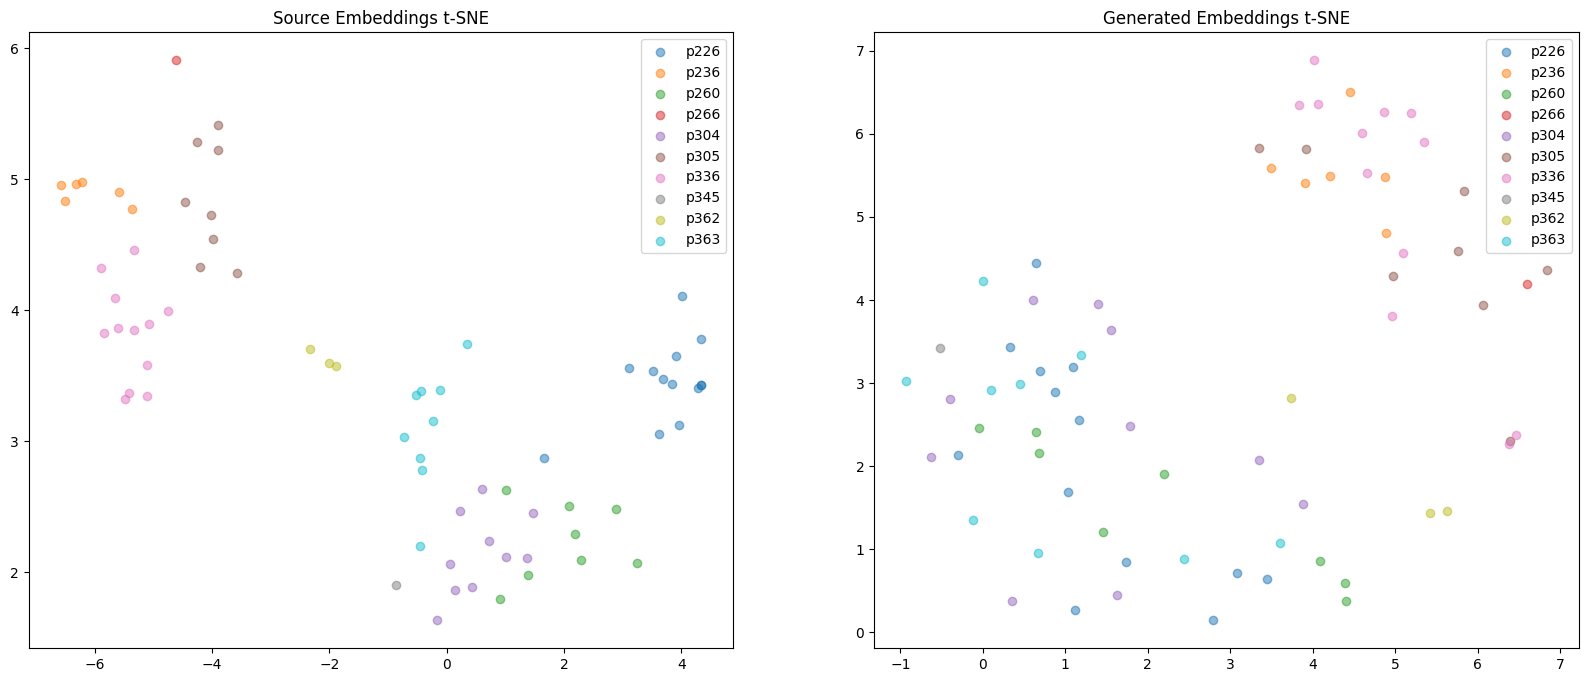

In [ ]:

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=50)
src_emb_tsne = tsne.fit_transform(src_emb_flattened)
gen_emb_tsne = tsne.fit_transform(gen_emb_flattened)

# Adjusted visualization function for side-by-side plotting
def plot_tsne_side_by_side(src_embeddings_tsne, src_labels, gen_embeddings_tsne, gen_labels):
    plt.figure(figsize=(20, 8))  # Adjust the figure size as necessary

    # Plot for Source Embeddings on the left
    plt.subplot(1, 2, 1)  # 1 row, 2 columns, subplot 1
    for label in np.unique(src_labels):
        idx = src_labels == label
        plt.scatter(src_embeddings_tsne[idx, 0], src_embeddings_tsne[idx, 1], label=label, alpha=0.5)
    plt.title('Source Embeddings t-SNE')
    plt.legend()

    # Plot for Generated Embeddings on the right
    plt.subplot(1, 2, 2)  # 1 row, 2 columns, subplot 2
    for label in np.unique(gen_labels):
        idx = gen_labels == label
        plt.scatter(gen_embeddings_tsne[idx, 0], gen_embeddings_tsne[idx, 1], label=label, alpha=0.5)
    plt.title('Generated Embeddings t-SNE')
    plt.legend()

    plt.show()

# Call the modified plotting function with both sets of t-SNE results
plot_tsne_side_by_side(src_emb_tsne, src_labels, gen_emb_tsne, gen_labels)